In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.layers import Embedding, GRU, Dense


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/cleaned-welfake/cleaned_welfake.csv')

In [3]:
df.head(3)

,Unnamed: 0,title,text,label,total_content
0,0,law enforcement high alert following threat co...,comment member movement hanging white people c...,1,law enforcement high alert following threat co...
1,2,unbelievable attorney general say rioter peace...,demonstrator last night constitutional right p...,1,unbelievable attorney general say rioter peace...
2,3,bobby raised us story conversion woo potential...,dozen politically active pastor came private d...,0,bobby raised us story conversion woo potential...


In [4]:
df = df.dropna()

In [5]:
df = df.drop(['title','Unnamed: 0','text'], axis=1)

In [6]:
df.head(3)

,label,total_content
0,1,law enforcement high alert following threat co...
1,1,unbelievable attorney general say rioter peace...
2,0,bobby raised us story conversion woo potential...


In [7]:
df.rename(columns = {'total_content':'text'}, inplace = True)

In [8]:
df.head(3)

,label,text
0,1,law enforcement high alert following threat co...
1,1,unbelievable attorney general say rioter peace...
2,0,bobby raised us story conversion woo potential...


In [9]:
# Spliting the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [10]:
# Separating the text and label columns in each set
train_texts = train_df['text'].values
train_labels = train_df['label'].values
val_texts = val_df['text'].values
val_labels = val_df['label'].values
test_texts = test_df['text'].values
test_labels = test_df['label'].values

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

In [12]:
# Convert text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [13]:
max_sequence_length = max(len(seq) for seq in train_sequences)
print(max_sequence_length)

8703


In [14]:
max_sequence_length = 300  # Adjust this value according to your data

In [15]:
# Pad sequences to have a fixed length
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
val_data = pad_sequences(val_sequences, maxlen=max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [16]:
# Load pre-trained GloVe embeddings
embedding_dim = 300  # Adjust this value based on the dimension of the GloVe embeddings you downloaded
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

In [17]:
glove_file = '/kaggle/input/glove6b300dtxt/glove.6B.300d.txt'  # Replace with the path to your GloVe file
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

In [18]:
# Model architecture
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          10453200  
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 10,618,449
Trainable params: 165,249
Non-trainable params: 10,453,200
_________________________________________________________________


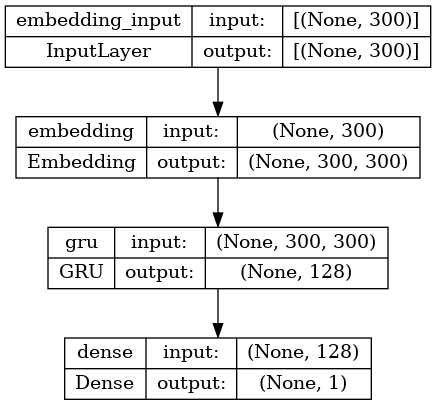

In [19]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [21]:
# Model training
batch_size = 64
epochs = 20

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [23]:
model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_labels), callbacks=[early_stopping])

Epoch 1/20
705/705 [==============================] - 26s 28ms/step - loss: 0.2720 - accuracy: 0.8868 - val_loss: 0.1828 - val_accuracy: 0.9299
Epoch 2/20
705/705 [==============================] - 18s 26ms/step - loss: 0.1522 - accuracy: 0.9419 - val_loss: 0.1451 - val_accuracy: 0.9446
Epoch 3/20
705/705 [==============================] - 18s 26ms/step - loss: 0.1077 - accuracy: 0.9593 - val_loss: 0.1241 - val_accuracy: 0.9556
Epoch 4/20
705/705 [==============================] - 18s 26ms/step - loss: 0.0745 - accuracy: 0.9731 - val_loss: 0.1174 - val_accuracy: 0.9596
Epoch 5/20
705/705 [==============================] - 18s 26ms/step - loss: 0.0461 - accuracy: 0.9831 - val_loss: 0.1253 - val_accuracy: 0.9596
Epoch 6/20
705/705 [==============================] - 18s 26ms/step - loss: 0.0259 - accuracy: 0.9913 - val_loss: 0.1489 - val_accuracy: 0.9584
Epoch 7/20
705/705 [==============================] - 18s 26ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.1572 - val_accuracy:

In [24]:
# Model evaluation
loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

441/441 [==============================] - 4s 8ms/step - loss: 0.1199 - accuracy: 0.9569
Test Loss: 0.1199
Test Accuracy: 0.9569


In [25]:
# Perform predictions on the test set
test_predictions = model.predict(test_data)
test_predictions = (test_predictions > 0.5).astype(int)

441/441 [==============================] - 3s 7ms/step


In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [28]:
# Calculate precision, recall, and F1-score
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1score = f1_score(test_labels, test_predictions)

In [29]:
# Print the metrics
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1score)

Precision: 0.9608034593388199
Recall: 0.9548100914887718
F1-Score: 0.9577973997079886
